# Lesson 5 - Facial Similarity Search

### Import the Needed Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
#from deepface import DeepFace
from sentence_transformers import SentenceTransformer
from pinecone import Pinecone, ServerlessSpec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
from tqdm import tqdm

import contextlib
import glob
import matplotlib.pyplot as plt
import numpy as np

import uuid

import os
import pandas as pd
import time

from PIL import Image

from dotenv import load_dotenv
load_dotenv()

True

In [4]:
PINECONE_API_KEY = os.getenv('PINECONE_API_KEY')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

### Load the Dataset

**Note:** To access the dataset outside of this course, just copy the following two lines of code and run it (remember to uncomment them first before executing):

#!wget -q --show-progress -O family_photos.zip "https://www.dropbox.com/scl/fi/yg0f2ynbzzd2q4nsweti5/family_photos.zip?rlkey=00oeuiii3jgapz2b1bfj0vzys&dl=0"

#!unzip -q family_photos.zip

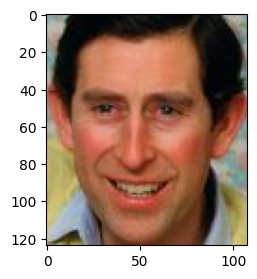

In [5]:
def show_img(f):
  img = plt.imread(f)
  plt.figure(figsize=(4,3))
  plt.imshow(img)

show_img('./data/family/dad/P06260_face5.jpg')

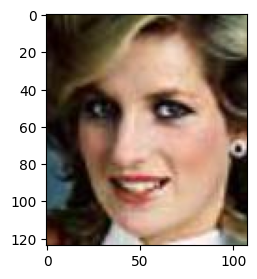

In [11]:
show_img('./data/family/mom/P04407_face2.jpg')


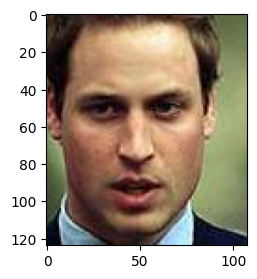

In [12]:
show_img('./data/family/child/P04414_face1.jpg')


### Setup Pinecone 

In [20]:
MODEL = "Facenet"
INDEX_NAME = f'dl-ai-{str(uuid.uuid4())}'

pinecone = Pinecone(api_key=PINECONE_API_KEY)

### Create Embeddings Using DeepFace

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model = SentenceTransformer('sentence-transformers/clip-ViT-B-32', device=device)

cpu


In [14]:
def generate_vectors():
  VECTOR_FILE = "./data/vectors.vec"

  with contextlib.suppress(FileNotFoundError):
    os.remove(VECTOR_FILE)
  with open(VECTOR_FILE, "w") as f:
    for person in ["mom", "dad", "child"]:
      files = glob.glob(f'./data/family/{person}/*')
      for file in tqdm(files):
        try:
          img = Image.open(file).convert('RGB')
          embedding = model.encode(img).tolist()
          f.write(f'{person}:{os.path.basename(file)}:{embedding}\n') 
        except (ValueError, UnboundLocalError, AttributeError) as e:
          print(e)

generate_vectors()

100%|██████████| 93/93 [00:03<00:00, 24.98it/s]


In [16]:
!head -10 ./data/vectors.vec

mom:P11987_face1.jpg:[0.251920223236084, -0.2321355640888214, -0.20004695653915405, -0.26098358631134033, 0.10883903503417969, 0.11413422971963882, -0.30956539511680603, -0.013446688652038574, 0.20226027071475983, 0.09330859780311584, 0.3443574011325836, 0.0787610113620758, 0.681220531463623, 0.03261948749423027, -0.2737486958503723, 0.3218002915382385, 1.1626778841018677, -0.4273773431777954, 0.5176885724067688, 0.22467678785324097, 0.42753052711486816, -0.3063260018825531, -0.20769651234149933, -0.45126569271087646, -0.040845371782779694, -0.20298707485198975, 0.03441730514168739, 0.09069457650184631, -0.295725554227829, 0.2347341775894165, 0.42301738262176514, -0.04889295995235443, -0.19224244356155396, -0.43050628900527954, -0.5242259502410889, 0.09163554012775421, -0.25391024351119995, 0.1175958663225174, -0.4835003614425659, 3.2704551219940186, 0.18530374765396118, -0.26698169112205505, -0.00381450355052948, -0.026869753375649452, -0.18598181009292603, 0.31668850779533386, -0.392

### Plot the Data of Images

In [21]:
def gen_tsne_df(person, perplexity):
    vectors =[]
    with open('./data/vectors.vec', 'r') as f:
      for line in tqdm(f):
        p, orig_img, v = line.split(':')
        if person == p:
            vectors.append(eval(v))
    pca = PCA(n_components=8)
    tsne = TSNE(2, perplexity=perplexity, random_state = 0, max_iter=1000,
        verbose=0, metric='euclidean', learning_rate=75)
    print(f'transform {len(vectors)} vectors')
    pca_transform = pca.fit_transform(vectors)
    embeddings2d = tsne.fit_transform(pca_transform)
    return pd.DataFrame({'x':embeddings2d[:,0], 'y':embeddings2d[:,1]})

In [ ]:
def plot_tsne(perplexity, model):
    (_, ax) = plt.subplots(figsize=(8,5))
    #plt.style.use('seaborn-whitegrid')
    plt.grid(color='#EAEAEB', linewidth=0.5)
    ax.spines['top'].set_color(None)
    ax.spines['right'].set_color(None)
    ax.spines['left'].set_color('#2B2F30')
    ax.spines['bottom'].set_color('#2B2F30')
    colormap = {'dad':'#ee8933', 'child':'#4fad5b', 'mom':'#4c93db'}

    for person in colormap:
        embeddingsdf = gen_tsne_df(person, perplexity)
        ax.scatter(embeddingsdf.x, embeddingsdf.y, alpha=.5, 
                   label=person, color=colormap[person])
    plt.title(f'Scatter plot of faces using {model}', fontsize=16, fontweight='bold', pad=20)
    plt.suptitle(f't-SNE [perplexity={perplexity}]', y=0.92, fontsize=13)
    plt.legend(loc='best', frameon=True)
    plt.show()

241it [00:00, 5766.40it/s]


transform 70 vectors


241it [00:00, 4140.68it/s]


transform 93 vectors


241it [00:00, 5086.00it/s]


transform 78 vectors


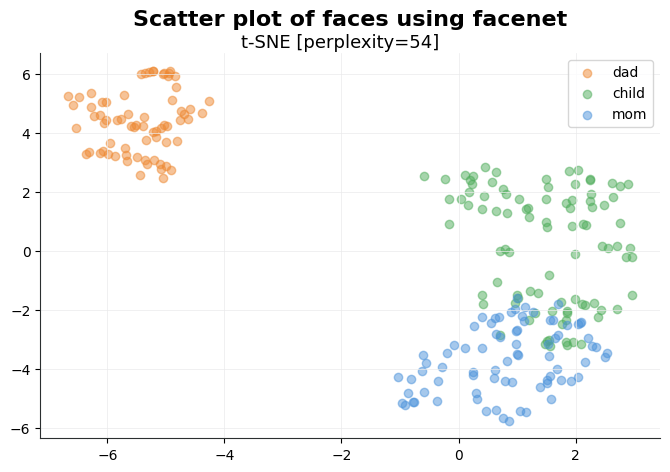

In [56]:
plot_tsne(54, 'facenet')

In [ ]:
num = 4
output = []
for i in range(1, num+1):
    result = 0
    for j in range(i, num+1):
        if j != i:
            result += i*j
        else:
            result = i
    result += i
    output.append(result)

print(output)

[10, 16, 15, 4]


### Store the Embeddings in Pinecone

In [77]:
output = []
for index in pinecone.list_indexes():
    output.append(index.name)
print(output)

['dl-ai-37ceb4ba-baca-4ded-8903-46c590082b36', 'vedclove-9f134f42-ccb8-4d22-b45c-63517e67b785', 'dl-ai-ehbsbzticlwqtafsvvpixsspbkmydweq', 'dl-ai-a2a81ace-42bd-4ff2-92a9-fc8f2ed1bd45', 'dl-ai-53388de1-fb38-4304-b520-590bc7feefb1']


In [86]:
INDEX_NAME = 'vedclove-9f134f42-ccb8-4d22-b45c-63517e67b785'

pinecone = Pinecone(api_key=PINECONE_API_KEY)

if INDEX_NAME in [index.name for index in pinecone.list_indexes()]:
  pinecone.delete_index(INDEX_NAME)
pinecone.create_index(name=INDEX_NAME, dimension=512, metric='cosine',
  spec=ServerlessSpec(cloud='aws', region='us-east-1'))

index = pinecone.Index(INDEX_NAME)

In [87]:
def store_vectors():
  with open("./data/vectors.vec", "r") as f:
    for line in tqdm(f):
        person, file, vec = line.split(':')
        index.upsert([(f'{person}-{file}', eval(vec), {"person":person, "file":file})])
store_vectors()

241it [00:50,  4.76it/s]


In [88]:
index.describe_index_stats()

{'_response_info': {'raw_headers': {'connection': 'keep-alive',
                                    'content-length': '185',
                                    'content-type': 'application/json',
                                    'date': 'Tue, 30 Dec 2025 06:57:46 GMT',
                                    'grpc-status': '0',
                                    'server': 'envoy',
                                    'x-envoy-upstream-service-time': '40',
                                    'x-pinecone-request-id': '3675117928154072220',
                                    'x-pinecone-request-latency-ms': '40',
                                    'x-pinecone-response-duration-ms': '42'}},
 'dimension': 512,
 'index_fullness': 0.0,
 'memoryFullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'__default__': {'vector_count': 241}},
 'storageFullness': 0.0,
 'total_vector_count': 241,
 'vector_type': 'dense'}

### Calculate the Similarity Scores

In [110]:
def test(vec_groups, parent, child):
  index = pinecone.Index(INDEX_NAME)
  parent_vecs = vec_groups[parent]
  K = 10
  SAMPLE_SIZE = 10
  sum = 0
  for i in tqdm(range(0,SAMPLE_SIZE)):
    query_response = index.query(
      top_k=K,
      vector = parent_vecs[i],
      filter={
        "person": {"$eq": child}
      }
    )
    for row in query_response["matches"]:
      sum  = sum + row["score"]
  print(f'\n{parent} AVG: {round(sum / (SAMPLE_SIZE*K), 2)}')

In [109]:
vec_groups = {"dad":[], "mom":[], "child":[]}
with open("./data/vectors.vec", "r") as f:
    for line in tqdm(f):
        person, file, vec = line.split(':')
        vec_groups[person].append(eval(vec))

parent_vecs = vec_groups['child']
len(parent_vecs)

241it [00:00, 1571.64it/s]


93

In [ ]:
def compute_scores():
  index = pinecone.Index(INDEX_NAME)
  vec_groups = {"dad":[], "mom":[], "child":[]}
  with open("./data/vectors.vec", "r") as f:
    for line in tqdm(f):
      person, file, vec = line.split(':')
      vec_groups[person].append(eval(vec))
  print(f"DAD {'-' * 20}")
  test(vec_groups, "dad", "child")
  print(f"MOM {'-' * 20}")
  test(vec_groups, "mom", "child")

compute_scores()

241it [00:00, 1679.29it/s]


DAD --------------------


100%|██████████| 10/10 [00:00<00:00, 10.54it/s]




dad AVG: 0.79
MOM --------------------


100%|██████████| 10/10 [00:00<00:00, 10.91it/s]



mom AVG: 0.76


### Check the Matching Images

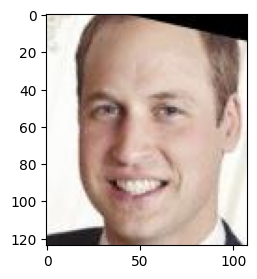

In [82]:
child_base = './data/family/child/P06310_face1.jpg'
show_img(child_base)

In [92]:
#Now find closest given we know dad is "most similar"
embedding = model.encode(child_base).tolist()
print(embedding)

[0.020603589713573456, -0.050827279686927795, -0.10876593738794327, 0.11513401567935944, 0.12641331553459167, -0.028249591588974, -0.10683514922857285, -0.8607630729675293, 0.27164608240127563, 0.16730475425720215, 0.2478814274072647, -0.22663871943950653, -0.10747349262237549, 0.07480522990226746, 0.24351920187473297, -0.08365902304649353, 0.25244322419166565, 0.04710227996110916, -0.3762780427932739, 0.5399383902549744, 0.2724416255950928, -0.004802413284778595, 0.17537713050842285, 0.33998990058898926, 0.03510776907205582, 0.21560624241828918, 0.015820637345314026, 0.022647179663181305, 0.04147928208112717, 0.11217109858989716, 0.5059157609939575, -0.10268725454807281, 0.03802192956209183, 0.03778165578842163, 0.12401393800973892, -0.047891125082969666, 0.05806565284729004, -0.1310000717639923, 0.03761277347803116, -0.22361502051353455, -0.4845516085624695, 0.04331415891647339, -0.07147844135761261, -0.10058540850877762, -0.15668191015720367, 0.20053337514400482, -0.0906701534986496

In [93]:
query_response = index.query(
      top_k=3,
      vector = embedding,
      filter={
        "person": {"$eq": "dad"}
      },
      include_metadata=True
)

In [94]:
print(query_response)


QueryResponse(matches=[{'id': 'dad-P06259_face3.jpg',
 'metadata': {'file': 'P06259_face3.jpg', 'person': 'dad'},
 'score': 0.274000108,
 'values': []}, {'id': 'dad-P06305_face0.jpg',
 'metadata': {'file': 'P06305_face0.jpg', 'person': 'dad'},
 'score': 0.267924041,
 'values': []}, {'id': 'dad-P06303_face1.jpg',
 'metadata': {'file': 'P06303_face1.jpg', 'person': 'dad'},
 'score': 0.266780674,
 'values': []}], namespace='', usage={'read_units': 1}, _response_info={'raw_headers': {'date': 'Tue, 30 Dec 2025 15:38:36 GMT', 'content-type': 'application/json', 'content-length': '413', 'connection': 'keep-alive', 'x-pinecone-max-indexed-lsn': '241', 'x-pinecone-request-latency-ms': '181', 'x-pinecone-request-id': '1142647767533527480', 'x-envoy-upstream-service-time': '181', 'x-pinecone-response-duration-ms': '183', 'grpc-status': '0', 'server': 'envoy'}})


In [95]:
photo = query_response['matches'][0]['metadata']['file']


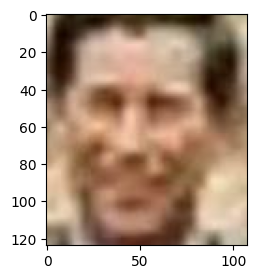

In [97]:
show_img(f'./data/family/dad/{photo}')
